<a href="https://colab.research.google.com/github/thenickestnick/image-generation-tools/blob/main/Generate_Images_with_Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@markdown # Run This Cell First
#@markdown This cell:
#@markdown 1. Checks for required GPU
#@markdown 2. Installs dependencies
#@markdown 3. Asks for your HuggingFace auth token. [Get one here](https://huggingface.co/settings/tokens)

#@markdown If you don't have a HuggingFace account, you will need one.

#@markdown [Click here to create a HuggingFace account](https://huggingface.co/join).

#@markdown ### Note: If you see a git warning after you supply your auth token, you can safely ignore it. 

import torch
assert torch.cuda.is_available(), "A GPU runtime is required. Switch to a GPU using Runtime > Change Runtime Type"
!nvidia-smi

!pip install --upgrade diffusers transformers

from huggingface_hub import notebook_login
notebook_login()

In [ ]:
#@markdown # Run This Cell Second
#@markdown This cell:
#@markdown 1. Imports required libraries. 
#@markdown 2. Sets up the pipeline and downloads models
#@markdown 3. Sets up the generation code and utility functions

#@markdown ### Note: This may take some time. The models are about 5 GB in size, so be patient :)
#@markdown Fortunately there are handy progress bars you can stare at.
import os
import numpy as np
from torch import autocast
from tqdm.notebook import tqdm
from IPython.display import display
from IPython.display import clear_output
from diffusers import StableDiffusionPipeline

torch.set_grad_enabled(False)

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"
pipe = StableDiffusionPipeline.from_pretrained(model_id, use_auth_token=True)
pipe = pipe.to(device)

def get_text_embedding(text):
  text_input = pipe.tokenizer(
      text,
      padding="max_length",
      max_length=pipe.tokenizer.model_max_length,
      truncation=True,
      return_tensors="pt",
  )
  return pipe.text_encoder(text_input.input_ids.to(pipe.device))[0]

blank_string_embeddings = get_text_embedding("")

def decode_latents(lat_batch):
  lat_batch = 1 / 0.18215 * lat_batch
  im_batch = pipe.vae.decode(lat_batch)
  im_batch = (im_batch / 2 + 0.5).clamp(0, 1)
  return im_batch

def generate(
    text_embedding, 
    num_iterations, 
    guidance_scale, 
    size=512, 
    init_latents=None):
  with torch.autocast('cuda'):
    if init_latents is not None:
      latents = init_latents
    else:
      latents = torch.randn((1, pipe.unet.in_channels, size // 8, size // 8), 
                            device=pipe.device)

    latents = torch.cat([latents]*2)
    text_embeddings = torch.cat([blank_string_embeddings, text_embedding])

    pipe.scheduler.set_timesteps(num_iterations, offset=1)

    for step_i, step in enumerate(tqdm(
        pipe.scheduler.timesteps, 
        desc='Generating', leave=False)):
      noise_pred = pipe.unet(latents, step, text_embeddings)['sample']

      # classifier-free guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = (noise_pred_uncond + 
                    guidance_scale * (noise_pred_text - noise_pred_uncond))
      latents = pipe.scheduler.step(noise_pred, step, latents)['prev_sample']
        
  latents = latents.chunk(2)[0]
  return latents


clear_output()
print('Everything checks out. Start diffusing using the cell below! ↓↓↓')

Generating:   0%|          | 0/51 [00:00<?, ?it/s]

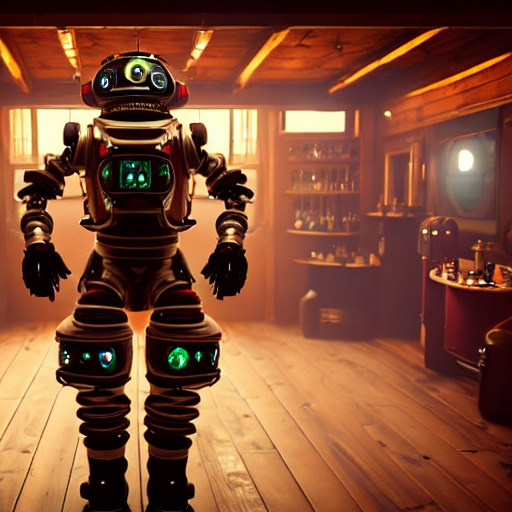

Saved as: /content/images/image_20220830223908.jpg | Seed: 8777370


Generating:   0%|          | 0/51 [00:00<?, ?it/s]

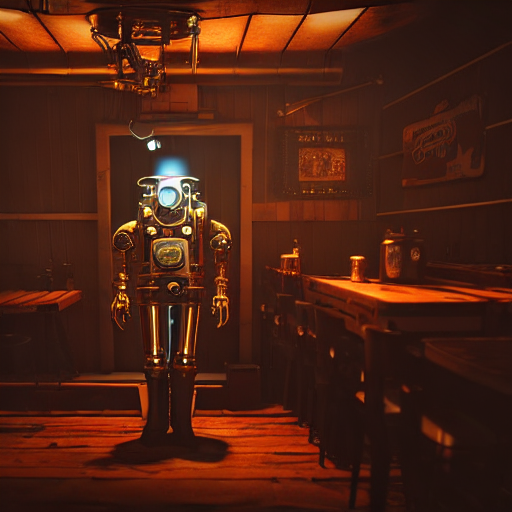

Saved as: /content/images/image_20220830223913.jpg | Seed: 29821


Generating:   0%|          | 0/51 [00:00<?, ?it/s]

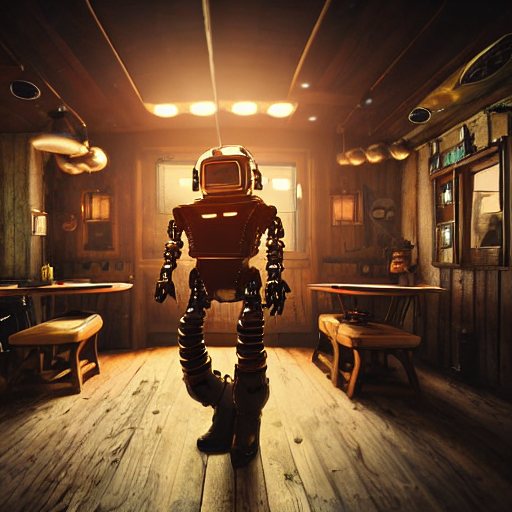

Saved as: /content/images/image_20220830223919.jpg | Seed: 481428


Generating:   0%|          | 0/51 [00:00<?, ?it/s]

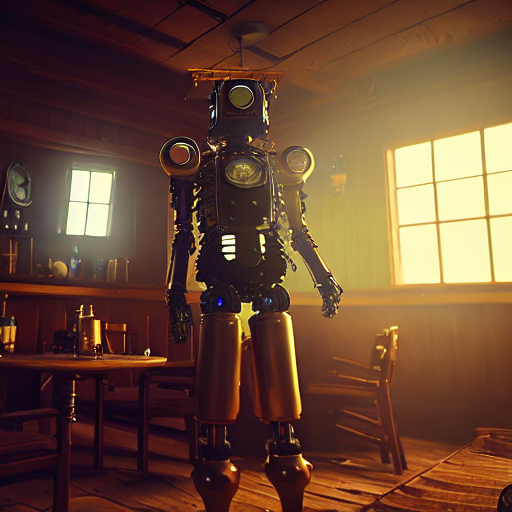

Saved as: /content/images/image_20220830223925.jpg | Seed: 1140434


In [15]:
#@markdown # Generate an image from a prompt
#@markdown Guidance on params:

#@markdown **prompt**: The text you want to use to generate the image.

#@markdown **num_iterations**: How many denoising iterations to run. *More is not necessarily better.* Values between 40 and 75 usually work well.

#@markdown **guidance_scale**: How much the prompt affects the final image. Values between 4 and 13 are pretty good usually. Depends on the prompt, you may need to experiment.

#@markdown **size**: Resolution of generated image (image will be square). *512 is a very safe size.* You can try higher numbers, but depending on the GPU colab allocated to you, you may cause the GPU to run out of memory. If this happens you may have to restart the runtime (Runtime > Restart Runtime) and rerun the setup cell above.

#@markdown **samples**: Number of images to generate.

#@markdown ### Example Prompts
#@markdown - ultrarealistic photo of a steampunk robot, dramatic lighting #unrealengine
#@markdown - realistic photo of a cat
#@markdown - surrealist painting of a lemur riding a unicycle

prompt = 'ultrarealistic photo of a space cowboy steampunk robot in a saloon, dramatic lighting #unrealengine' #@param {type:"string"}
num_iterations = 50 #@param {type:"integer"}
guidance_scale = 12 #@param {type:"number"}
size = 512 #@param {type:"number"}
samples = 4 #@param {type:"number"}

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

import torchvision.transforms.functional as F
from datetime import datetime

def timestamp():
    return datetime.now().strftime("%Y%m%d%H%M%S")

seeds = torch.randint(0, 9999999, (samples,))
prompt_embed = get_text_embedding(prompt)
os.makedirs('/content/images', exist_ok=True)

for seed in seeds:
  torch.manual_seed(seed)
  lat = generate(prompt_embed, num_iterations, guidance_scale, size)
  im = F.to_pil_image(decode_latents(lat).squeeze())
  save_path = f'/content/images/image_{timestamp()}.jpg'
  im.save(save_path, quality=90)
  display(im)
  print(f'Saved as: {save_path} | Seed: {seed}')


In [ ]:
#@markdown # [Optional] Save images to Google Drive
#@markdown Running this cell will mount your Google Drive (you will be asked to authorize this through a popup window)\
#@markdown and save your generated images to a drive folder called "stable_diffusion_images".

from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/drive/MyDrive/stable_diffusion_images
!cp -v images/* /content/drive/MyDrive/stable_diffusion_images
